In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bemcs
import utilfunctions as UF
import warnings
from matplotlib.colors import LogNorm

# Suppress all warnings
warnings.filterwarnings("ignore")

Numba is installed. Version: 0.62.1


# Topographic Loading in an Elastic Medium using the Boundary Element Method

## Introduction

This notebook demonstrates:

- Building a simple 2D surface mesh representing topography.

- Computing stress and displacement kernels using `bemcs``.

- Solving for tractions due to lithostatic loading.

- Adding a localized landslide perturbation.

- Visualizing stress changes in the medium.

---

## Constructing the Surface Mesh

We generate a simple 1D surface using a logistic-shaped topography. Each segment becomes an element in the BEM mesh.


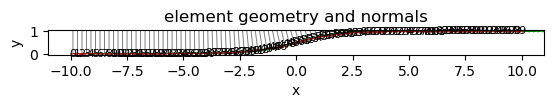

In [2]:
# construct mesh
Lscale = 10
npts = 101
hmax = 1
xvals = np.linspace(-Lscale, Lscale, npts)
yvals = UF.logistic(xvals, L=hmax, k=1, x0=0)

x1 = xvals[0:-1]
x2 = xvals[1:]
y1 = yvals[0:-1]
y2 = yvals[1:]
BCtype = np.array([f"t_global" for i in range(npts - 1)])

# construct mesh
els = bemcs.initialize_els()

els.x1 = x1
els.y1 = y1
els.x2 = x2
els.y2 = y2

bemcs.standardize_els_geometry(els, reorder=True)
bemcs.plot_els_geometry(els)

## Define Material Properties

In [3]:
# Elastic parameters and lithostatic effects
mu = 1  # normalized units (mostly does not matter for topographic problem)
nu = 0.25  # Poisson's ratio
rho = 1  # rho*g/mu
ydatum = 0  # provide a datum for verticals

## Observation Grid and Compute Kernels

A rectangular grid where stresses will be evaluated.

In [4]:
# Compute displacement & stress kernels
# Observation points
n_obs = 100

x_obs = np.linspace(Lscale * -0.5, Lscale * 0.5, n_obs)
y_obs = np.linspace(-2 * hmax, 1.2 * hmax, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

## Solve for Lithostatic Topographic Loading

In [5]:
# first solve topographic load problem
ydatum = 0
rhog = 1  # normalized
λ = 1  # tectonic overstress
BCval = rhog * (els.y_centers - ydatum)
bc_x = λ * nu / (1 - nu) * BCval * els.x_normals
bc_y = BCval * els.y_normals
quadratic_coefs_s, quadratic_coefs_n = UF.solve_bem_system(els, bc_x, bc_y, BCtype)
# Compute stresses
_, _, sxx, syy, _ = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)
# compute pressure in the medium
pressure = (sxx + syy) / 2 - rho * (y_obs.reshape(-1, 1) - ydatum)

Number of open nodes = 2
: [array([0]), array([299])]
Number of 2-overlap nodes = 99
: [array([ 3, -2]), array([ 6, -5]), array([ 9, -8]), array([ 12, -11]), array([ 15, -14]), array([ 18, -17]), array([ 21, -20]), array([ 24, -23]), array([ 27, -26]), array([ 30, -29]), array([ 33, -32]), array([ 36, -35]), array([ 39, -38]), array([ 42, -41]), array([ 45, -44]), array([ 48, -47]), array([ 51, -50]), array([ 54, -53]), array([ 57, -56]), array([ 60, -59]), array([ 63, -62]), array([ 66, -65]), array([ 69, -68]), array([ 72, -71]), array([ 75, -74]), array([ 78, -77]), array([ 81, -80]), array([ 84, -83]), array([ 87, -86]), array([ 90, -89]), array([ 93, -92]), array([ 96, -95]), array([ 99, -98]), array([ 102, -101]), array([ 105, -104]), array([ 108, -107]), array([ 111, -110]), array([ 114, -113]), array([ 117, -116]), array([ 120, -119]), array([ 123, -122]), array([ 126, -125]), array([ 129, -128]), array([ 132, -131]), array([ 135, -134]), array([ 138, -137]), array([ 141, -140]

## Define a Localized Landslide Load and Compute BEM Solve

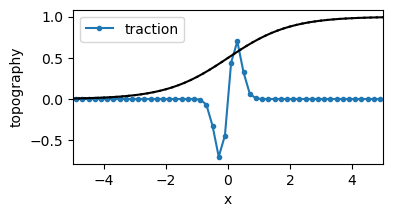

Number of open nodes = 2
: [array([0]), array([299])]
Number of 2-overlap nodes = 99
: [array([ 3, -2]), array([ 6, -5]), array([ 9, -8]), array([ 12, -11]), array([ 15, -14]), array([ 18, -17]), array([ 21, -20]), array([ 24, -23]), array([ 27, -26]), array([ 30, -29]), array([ 33, -32]), array([ 36, -35]), array([ 39, -38]), array([ 42, -41]), array([ 45, -44]), array([ 48, -47]), array([ 51, -50]), array([ 54, -53]), array([ 57, -56]), array([ 60, -59]), array([ 63, -62]), array([ 66, -65]), array([ 69, -68]), array([ 72, -71]), array([ 75, -74]), array([ 78, -77]), array([ 81, -80]), array([ 84, -83]), array([ 87, -86]), array([ 90, -89]), array([ 93, -92]), array([ 96, -95]), array([ 99, -98]), array([ 102, -101]), array([ 105, -104]), array([ 108, -107]), array([ 111, -110]), array([ 114, -113]), array([ 117, -116]), array([ 120, -119]), array([ 123, -122]), array([ 126, -125]), array([ 129, -128]), array([ 132, -131]), array([ 135, -134]), array([ 138, -137]), array([ 141, -140]

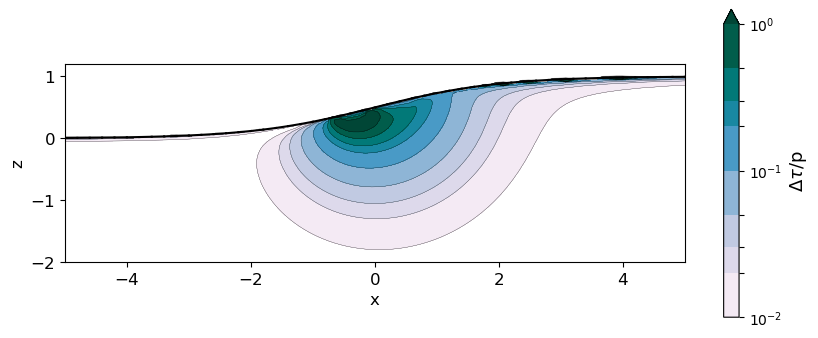

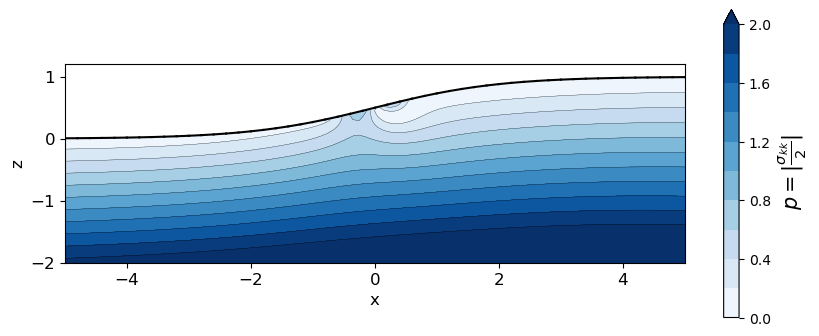

In [7]:
# compute mass change due to a landslide
landslide_x0 = 0
landslide_amp = -0.3
landslide_sigma = 0.25  # length-scale
BCval = (
    rho
    * landslide_amp
    * -(els.x_centers - landslide_x0)
    / (landslide_sigma**2)
    * np.exp(-((els.x_centers - landslide_x0) ** 2) / 2 / (landslide_sigma**2))
)
plt.figure(figsize=(4, 2))
plt.plot(els.x_centers, BCval, ".-", label="traction")
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.ylabel("topography")
plt.xlabel("x")
plt.legend()
plt.xlim([-Lscale / 2, Lscale / 2])
plt.show()

# solve BEM problem with appropriate boundary conditions
bc_x = BCval * els.x_normals
bc_y = BCval * els.y_normals
quadratic_coefs_s, quadratic_coefs_n = UF.solve_bem_system(els, bc_x, bc_y, BCtype)

# Compute displacement and stresses and plot all components
_, _, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

# bemcs.plot_displacements_stresses_els(
#     els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=31
# )

# first remove all values above topography
index = bemcs.inpolygon(
    x_obs,
    y_obs,
    np.hstack((els.x_centers, 100, 100, -100)),
    np.hstack((els.y_centers, 10, -10, -10)),
)


plt.figure(figsize=(10, 4))
# plot second invariant of stress
toplot = np.sqrt(1 / 4 * (sxx - syy) ** 2 + sxy**2) / np.abs(pressure + (sxx + syy) / 2)
toplot[~index, 0] = 0  # np.nan
toplot = toplot.reshape(n_obs, n_obs)
# provide min/max values to plot
# maxval = landslide_amp / landslide_sigma / np.sqrt(np.exp(1))
maxval = 1
minval = 0.01
# levels = np.logspace(np.log10(minval), np.log10(maxval), 11)
levels = np.array([0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10]) / 10
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="PuBuGn",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    norm=LogNorm(),
    extend="max",
)
cb = plt.colorbar(img, shrink=1.0)
cb.ax.tick_params(labelsize=10)
cb.set_label("$\Delta\\tau$/p", fontsize=13)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    colors="black",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    linewidths=0.2,
)
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim([-0.5 * Lscale, 0.5 * Lscale])
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.tick_params(labelsize=12)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

plt.figure(figsize=(10, 4))
# plot pressure due to topography
toplot = np.abs(-pressure + (sxx + syy) / 2)
toplot[~index, 0] = np.nan
toplot = toplot.reshape(n_obs, n_obs)
maxval = 2
minval = 0.0
levels = np.linspace(minval, maxval, 11)
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="Blues",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    extend="max",
)
cb = plt.colorbar(img, shrink=1.0)
cb.ax.tick_params(labelsize=10)
cb.set_label("$p=|\\frac{\\sigma_{kk}}{2}|$", fontsize=15)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    colors="black",
    vmin=minval,
    vmax=maxval,
    levels=levels,
    linewidths=0.2,
)
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim([-0.5 * Lscale, 0.5 * Lscale])
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.tick_params(labelsize=12)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()